In [2]:
import os
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



In [3]:
big_data = pd.read_csv('/Users/ishan/Desktop/cs229-final-project/big_data.csv')

In [4]:
big_data = big_data.drop(['Unnamed: 0', 'game_id', 'game_date'], axis = 1)

In [5]:
bad_rows = []
for idx, row in big_data.iterrows():
    if idx % 2000 == 0: print(idx)
    if str(row['run_location']) == "nan" and str(row['pass_location']) == "nan":
        bad_rows.append(idx)
big_data.drop(bad_rows, inplace=True)

0
2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
30000
32000
34000
36000
38000
40000
42000
44000
46000
48000
50000
52000
54000
56000
58000
60000
62000
64000
66000
68000
70000
72000
74000
76000
78000
80000
82000
84000
86000
88000
90000
92000
94000
96000
98000
100000
102000
104000
106000
108000
110000
112000
114000
116000
118000
120000
122000
124000
126000
128000
130000
132000
134000
136000
138000
140000
142000
144000
146000
148000
150000
152000
154000
156000
158000
160000
162000
164000
166000
168000
170000
172000
174000
176000
178000
180000
182000
184000
186000
188000
190000
192000
194000
196000
198000
200000
202000
204000
206000
208000
210000
212000
214000
216000
218000
220000
222000
224000
226000
228000
230000
232000
234000
236000
238000


In [6]:
# cut down number of defense packages
dp_freq = dict(big_data['defense_personnel'].value_counts())
dp_freq[np.NaN] = 0
defense_package = []
for idx, row in big_data.iterrows():
    if dp_freq[row['defense_personnel']] < 450 or row['defense_personnel'] == np.NaN:
        defense_package.append(np.NaN)
    else:
        defense_package.append(row['defense_personnel'])
big_data = big_data.drop(['defense_personnel'],axis=1)
big_data['defense_personnel'] = defense_package

# cut down number of offense packages
op_freq = dict(big_data['offense_personnel'].value_counts())
op_freq[np.NaN] = 0
offense_package = []
for idx, row in big_data.iterrows():
    if op_freq[row['offense_personnel']] < 450 or row['offense_personnel'] == np.NaN:
        offense_package.append(np.NaN)
    else:
        offense_package.append(row['offense_personnel'])
big_data = big_data.drop(['offense_personnel'],axis=1)
big_data['offense_personnel'] = offense_package

In [7]:
# Building y values 

outcome_run_pass = []
outcome_buckets = []
for idx, row in big_data.iterrows():
    if row['play_type'] == 'pass':
        outcome_run_pass.append('pass')
        outcome_buckets.append('pass + ' + str(row['pass_location']))
    elif row['play_type'] == 'run':
        outcome_run_pass.append('run')
        outcome_buckets.append('run + ' + str(row['run_location']))

In [8]:
X = big_data.drop(['play_sequence_num','pass_length', 'home_team', 'away_team', 'pass_location', 'run_location', 'play_type', 'surface'], axis=1)

In [9]:
X.head()

,yardline_100,game_seconds_remaining,down,ydstogo,no_huddle,shotgun,posteam_timeouts_remaining,defteam_timeouts_remaining,score_differential,roof,offense_formation,defenders_in_box,feelslike,humidity,conditions,windspeed,defense_personnel,offense_personnel
0,86.0,3597.0,1.0,10.0,0.0,0.0,3.0,3.0,0.0,outdoors,I_FORM,8.0,79.0,61.1,Partially cloudy,12.0,"4 DL, 3 LB, 4 DB","2 RB, 1 TE, 2 WR"
1,80.0,3572.0,2.0,4.0,1.0,1.0,3.0,3.0,0.0,outdoors,SHOTGUN,6.0,79.0,61.1,Partially cloudy,12.0,"4 DL, 3 LB, 4 DB","2 RB, 1 TE, 2 WR"
2,75.0,3541.0,1.0,10.0,1.0,1.0,3.0,3.0,0.0,outdoors,SHOTGUN,7.0,79.0,61.1,Partially cloudy,12.0,"4 DL, 3 LB, 4 DB","2 RB, 1 TE, 2 WR"
3,75.0,3515.0,2.0,10.0,1.0,0.0,3.0,3.0,0.0,outdoors,I_FORM,7.0,79.0,61.1,Partially cloudy,12.0,"4 DL, 3 LB, 4 DB","2 RB, 1 TE, 2 WR"
4,66.0,3474.0,3.0,1.0,1.0,0.0,3.0,3.0,0.0,outdoors,I_FORM,8.0,79.0,61.1,Partially cloudy,12.0,"4 DL, 3 LB, 4 DB","1 RB, 2 TE, 2 WR"


In [14]:
X.shape

(228927, 72)

In [10]:
X.fillna(0, inplace=True)

In [11]:
print(outcome_run_pass)

['run', 'pass', 'run', 'pass', 'run', 'pass', 'run', 'pass', 'pass', 'pass', 'pass', 'pass', 'pass', 'run', 'pass', 'run', 'pass', 'pass', 'run', 'pass', 'run', 'pass', 'run', 'pass', 'run', 'pass', 'pass', 'pass', 'pass', 'run', 'run', 'run', 'pass', 'pass', 'run', 'run', 'pass', 'pass', 'run', 'pass', 'run', 'pass', 'run', 'run', 'run', 'run', 'pass', 'run', 'pass', 'pass', 'run', 'pass', 'pass', 'pass', 'run', 'run', 'pass', 'pass', 'run', 'run', 'run', 'pass', 'run', 'pass', 'pass', 'run', 'pass', 'run', 'pass', 'run', 'run', 'run', 'run', 'pass', 'pass', 'pass', 'pass', 'pass', 'pass', 'run', 'pass', 'pass', 'run', 'run', 'pass', 'run', 'pass', 'pass', 'run', 'pass', 'run', 'pass', 'run', 'pass', 'pass', 'run', 'pass', 'pass', 'run', 'run', 'run', 'run', 'run', 'pass', 'pass', 'pass', 'pass', 'pass', 'run', 'run', 'run', 'run', 'run', 'run', 'pass', 'pass', 'run', 'run', 'pass', 'pass', 'run', 'pass', 'run', 'pass', 'run', 'run', 'pass', 'run', 'pass', 'pass', 'run', 'pass', 'pass

In [12]:
X.head()

,yardline_100,game_seconds_remaining,down,ydstogo,no_huddle,shotgun,posteam_timeouts_remaining,defteam_timeouts_remaining,score_differential,roof,offense_formation,defenders_in_box,feelslike,humidity,conditions,windspeed,defense_personnel,offense_personnel
0,86.0,3597.0,1.0,10.0,0.0,0.0,3.0,3.0,0.0,outdoors,I_FORM,8.0,79.0,61.1,Partially cloudy,12.0,"4 DL, 3 LB, 4 DB","2 RB, 1 TE, 2 WR"
1,80.0,3572.0,2.0,4.0,1.0,1.0,3.0,3.0,0.0,outdoors,SHOTGUN,6.0,79.0,61.1,Partially cloudy,12.0,"4 DL, 3 LB, 4 DB","2 RB, 1 TE, 2 WR"
2,75.0,3541.0,1.0,10.0,1.0,1.0,3.0,3.0,0.0,outdoors,SHOTGUN,7.0,79.0,61.1,Partially cloudy,12.0,"4 DL, 3 LB, 4 DB","2 RB, 1 TE, 2 WR"
3,75.0,3515.0,2.0,10.0,1.0,0.0,3.0,3.0,0.0,outdoors,I_FORM,7.0,79.0,61.1,Partially cloudy,12.0,"4 DL, 3 LB, 4 DB","2 RB, 1 TE, 2 WR"
4,66.0,3474.0,3.0,1.0,1.0,0.0,3.0,3.0,0.0,outdoors,I_FORM,8.0,79.0,61.1,Partially cloudy,12.0,"4 DL, 3 LB, 4 DB","1 RB, 2 TE, 2 WR"


In [15]:
X = pd.get_dummies(X)

In [16]:
X.shape


(228927, 72)

In [19]:
Y = outcome_run_pass
Y = np.ravel(Y)

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=1)

In [22]:
print(len(X_train))

171695


In [23]:
print(len(X_test))


57232


In [48]:
NN = MLPClassifier(max_iter=500, activation='relu', hidden_layer_sizes=(100, 100))

In [49]:
MLPRegressor

sklearn.neural_network._multilayer_perceptron.MLPRegressor

In [52]:
NN.fit(X_train, Y_train)
NN_prediction = NN.predict(X_test)


# print("Mean Squared Error is" + str(mean_squared_error(Y_test, NN_prediction)))
# print("Mean Absolute Error is" + str(mean_absolute_error(Y_test, NN_prediction)))



In [53]:
print("Accuracy is", accuracy_score(Y_test, NN_prediction))
print("Confusion Matrix:\n", confusion_matrix(Y_test, NN_prediction))


Accuracy is 0.7354277327369304
Confusion Matrix:
 [[26197  6710]
 [ 8432 15893]]


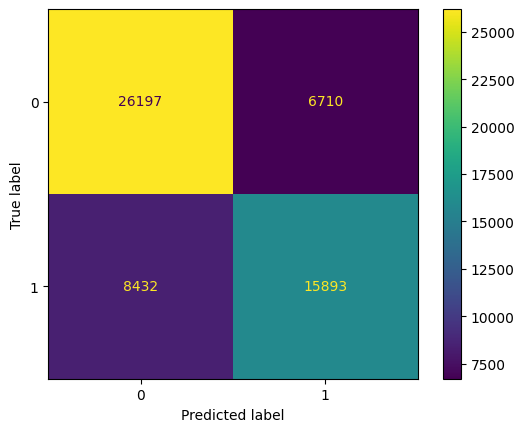

In [57]:
# Confusion Matrix

cm = confusion_matrix(Y_test, NN_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
labels = ['Pass', 'Run']
disp.plot()
plt.show()

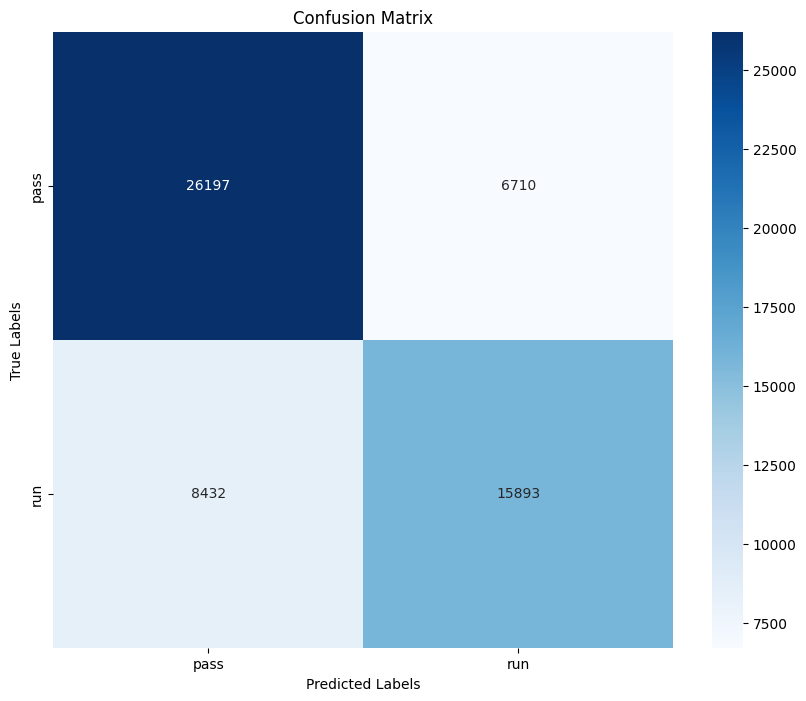

In [59]:
conf_matrix = confusion_matrix(Y_test, NN_prediction)
class_report = classification_report(Y_test, NN_prediction)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=set(outcome_run_pass), yticklabels=set(outcome_run_pass))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [64]:
# Neural net ratios

print(15893/(8432 + 15893))
print(26197 / (26197 + 6710))




0.653360739979445
0.7960920168961011


In [67]:
# Logreg ratios

print(12337/(12337 + 7239))
print(20811 / (20811 + 5399))



0.6302104617899469
0.7940099198779091
